In [1]:
# from googlefinance import getQuotes
# from yahoo_finance_api2 import share
import json
import datetime
import pandas as pd
# import pandas_datareader as web
# from pandas_datareader import data, wb

import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin
import matplotlib.pyplot as plt

from commons import read_xls, get_stock_data, NSE_BSE, save_csv, get_holding_quantities #, BSE_NSE
from consts import OUT_DIR, HOLDING_FILE
import datetime

In [2]:
### Query Period and timeframe
START = dt.datetime(2015, 1, 1) #dt.datetime(2020, 1, 1)
END = dt.datetime.today()
INTERVAL = '1wk' #'1d'
QTYS = get_holding_quantities()
PNG_FOLDER_NAME ='fundamental_data/'

BSE_NSE = {NSE_BSE[n]:n for n in QTYS.keys()}
init_df = pd.DataFrame()

In [3]:
def get_first_non_nan(df):
    df1 = df.fillna('NULL')
    d = dict()
    for s in QTYS.keys():
        for v in df1[s].to_list():
            if v != 'NULL':
                break

        d[s] = v
        
    return pd.Series(d)

************************ Calculating as per: ~/Documents/apps/docs/Holdings_20Dec24.xlsx ***************************

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  20 of 20 completed


Saved: /Users/imran/Documents/apps/docs/outputs/historical_port_data_20241220211435.csv


/var/folders/1_/wt7ckppx321bd_yhd2m3pb940000gn/T/ipykernel_52084/328785622.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig_plots[i][j].legend(fontsize = 15, loc='upper left') #loc=1


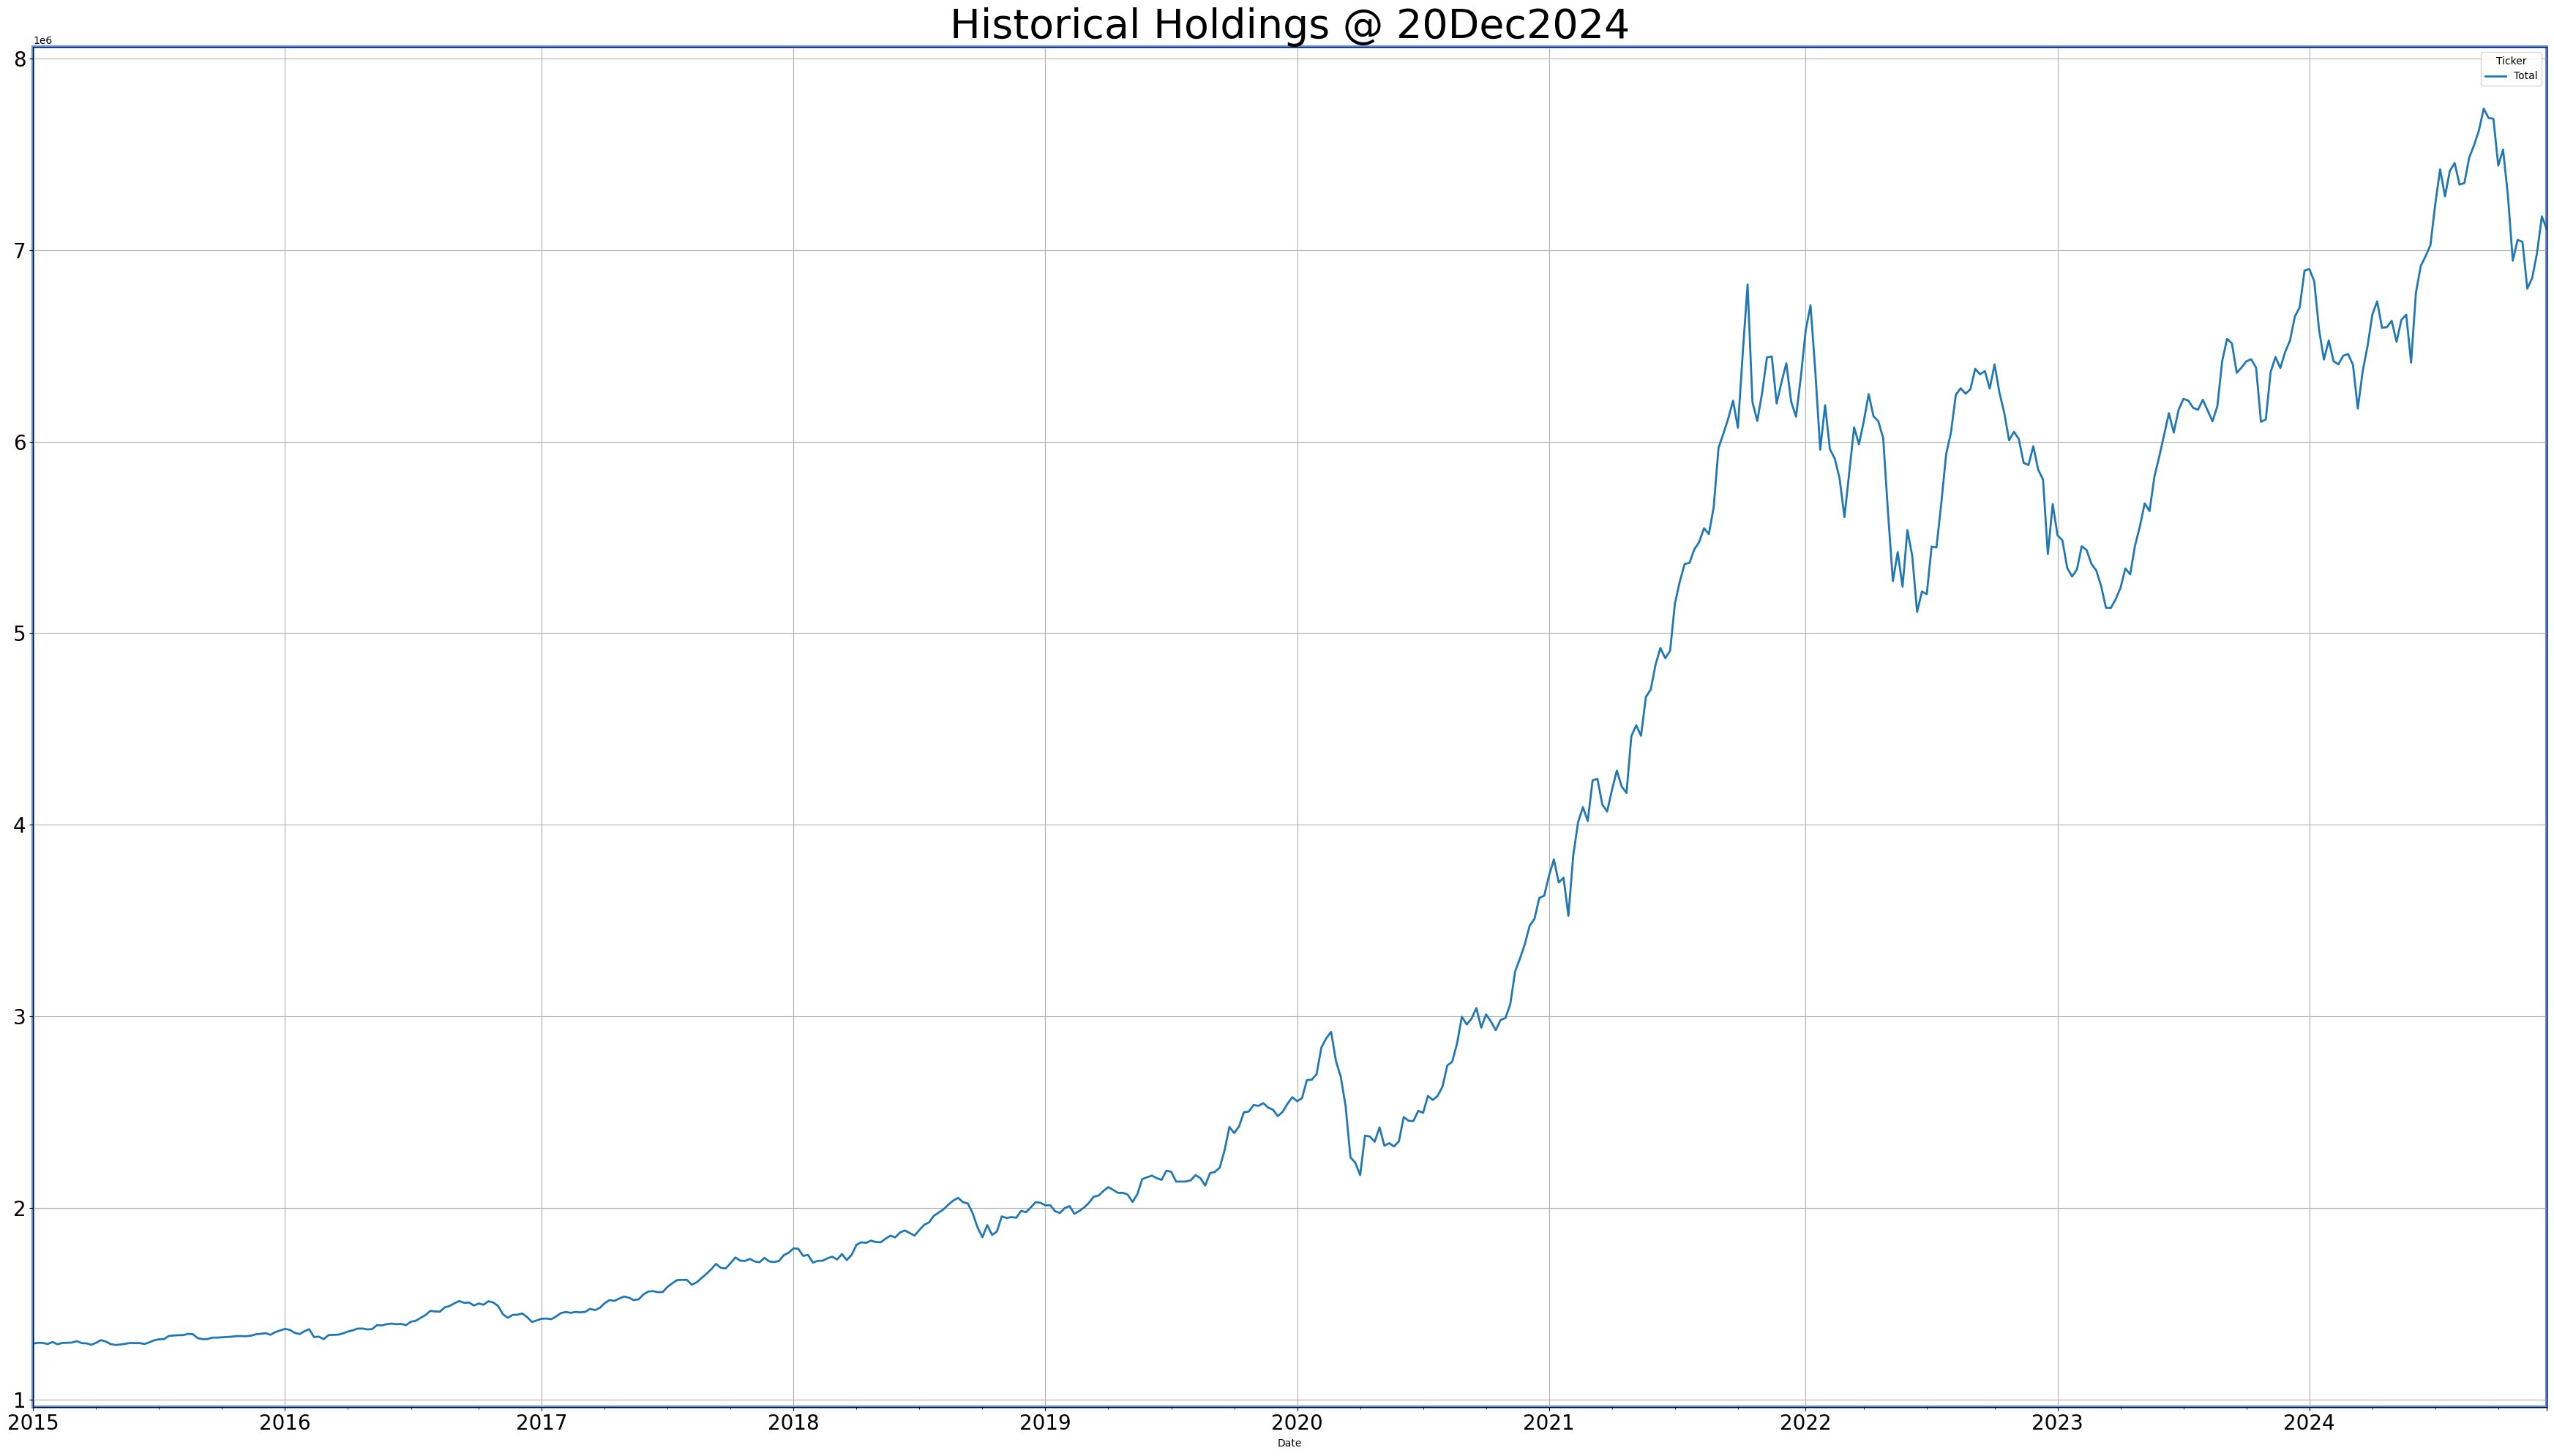

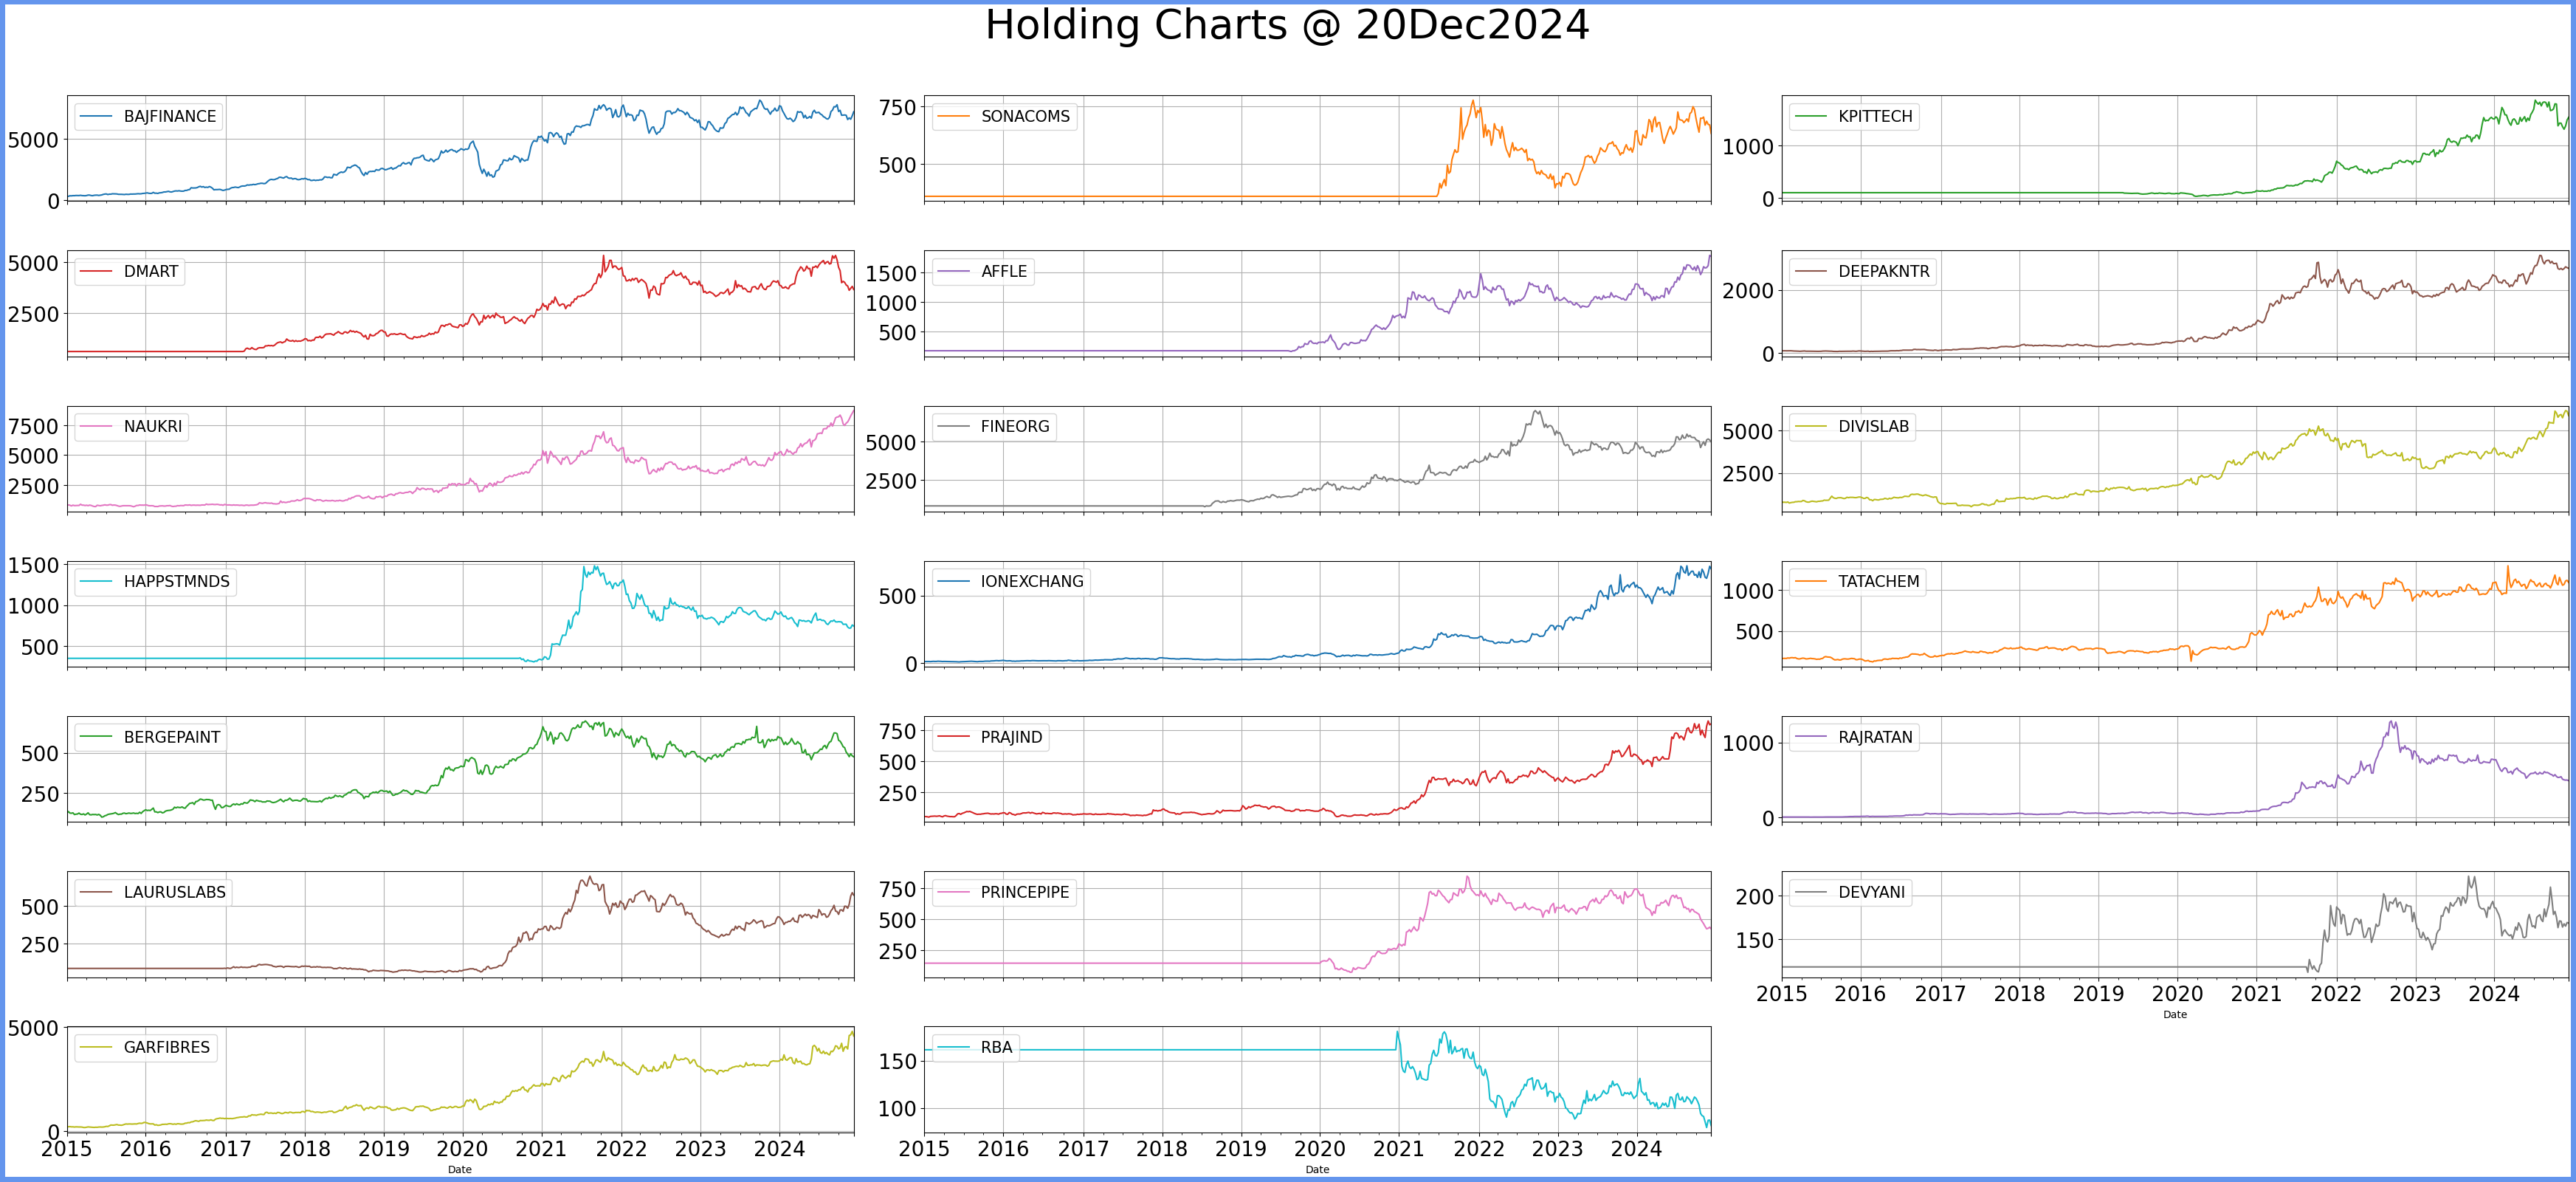

In [4]:
print(f'************************ Calculating as per: {HOLDING_FILE} ***************************\n')

stocks = [NSE_BSE[s] for s in QTYS.keys()] # list(NSE_BSE.values())
yfin.pdr_override()

if init_df.empty:
    init_df = pdr.get_data_yahoo(stocks, start=START, end=END, interval=INTERVAL)
else:
    print('df already loaded, using from cache!')

df = init_df.copy()

if INTERVAL == '1wk':
    df = df.asfreq('W-FRI', method='pad')

df = df['Adj Close']
df = df.rename(columns=BSE_NSE)


# df.mean()
# df = df.fillna(df.mean())
# https://stackoverflow.com/questions/42137529/pandas-find-first-non-null-value-in-column
# print(df.loc[~df.isnull().sum(1).astype(bool)].iloc[0]) ### Buggy... HAPPSTMNDS wrong

# Fill first listed value previously for new stocks
df1 = df.fillna(get_first_non_nan(df))

for k in QTYS.keys():
    df1[f'{k}_QTY'] = QTYS[k]

# print(df)

def myfunc(k):
#     print(f"{type(k)}, {k.loc['AFFLE']} ")
    val = 0
    for name in QTYS.keys():
        val += k[name] * k[f'{name}_QTY']
    return val

df['Total'] = df1.apply(myfunc, axis=1)

### Save
save_csv(df, 'historical_port_data')

### Plot Total and all shares
# fig_total = df[['Total']].plot(grid=True, figsize=(35,20), title='Historical Holdings', fontsize=25)
fig_total = df[['Total']].plot(grid=True, figsize=(35,20), fontsize=20, linewidth=2)
fig_total.set_title(f'Historical Holdings @ {datetime.datetime.today().strftime('%d%b%Y')}', pad=5, fontdict={'fontsize':40})
fig_total.get_figure().tight_layout()

# fig_total.suptitle('Holdings Historically', fontsize=30)
fig_total.patch.set_linewidth(3)
fig_total.patch.set_edgecolor('cornflowerblue')
fig_total.figure.savefig(f'{OUT_DIR}{PNG_FOLDER_NAME}historical_portfolio_value.png')
                  
fig_plots = df1[QTYS.keys()].plot(subplots=True, layout=(9,3), figsize=(35,20), grid=True)
ax = fig_plots[0][0]
for i in range(8):
    for j in range(3):
        fig_plots[i][j].legend(fontsize = 15, loc='upper left') #loc=1
        fig_plots[i][j].tick_params(axis='x', which='both', labelsize=20)
        fig_plots[i][j].tick_params(axis='y', which='both', labelsize=20)

fig_plots = ax.get_figure()
fig_plots.tight_layout()
fig_plots.subplots_adjust(top=0.92)
fig_plots.suptitle(f'Holding Charts @ {datetime.datetime.today().strftime('%d%b%Y')}', fontsize=40)
fig_plots.patch.set_linewidth(10)
fig_plots.patch.set_edgecolor('cornflowerblue')
fig_plots.savefig(f'{OUT_DIR}{PNG_FOLDER_NAME}holding_charts.png')




In [5]:
dir(fig_total)
fig_total.get_figure().tight_layout()


In [6]:
QTYS


{'BAJFINANCE': 128.0,
 'SONACOMS': 1098.0,
 'KPITTECH': 441.0,
 'DMART': 167.0,
 'AFFLE': 320.0,
 'DEEPAKNTR': 173.0,
 'NAUKRI': 49.0,
 'FINEORG': 84.0,
 'DIVISLAB': 64.0,
 'HAPPSTMNDS': 411.0,
 'IONEXCHANG': 426.0,
 'TATACHEM': 238.0,
 'BERGEPAINT': 543.0,
 'PRAJIND': 232.0,
 'RAJRATAN': 342.0,
 'LAURUSLABS': 289.0,
 'PRINCEPIPE': 358.0,
 'DEVYANI': 355.0,
 'GARFIBRES': 13.0,
 'RBA': 551.0}

In [7]:
import os
import pandas as pd
import datetime
from pandas_datareader import data as pdr
import yfinance as yfin

from consts import NSE_BSE, OUT_DIR, HOLDING_FILE

df = read_xls(HOLDING_FILE, tab=0)
df = df[['Symbol', 'Qty', 'Curr Val']]
df = df.sort_values('Curr Val', ascending=False)
df = df[df['Qty'] > 0][['Symbol', 'Qty']]
# df = df[df['Qty'] > 0]
# dir(df)
# df.to_json()
list(df.values)
df_dict = df.to_dict('list') # https://stackoverflow.com/questions/52547805/how-to-convert-dataframe-to-dictionary-in-pandas-without-index

qtys = {}
for c, v in zip(df_dict['Symbol'], df_dict['Qty']):
    qtys[c] = v

qtys


{'BAJFINANCE': 128.0,
 'SONACOMS': 1098.0,
 'KPITTECH': 441.0,
 'DMART': 167.0,
 'AFFLE': 320.0,
 'DEEPAKNTR': 173.0,
 'NAUKRI': 49.0,
 'FINEORG': 84.0,
 'DIVISLAB': 64.0,
 'HAPPSTMNDS': 411.0,
 'IONEXCHANG': 426.0,
 'TATACHEM': 238.0,
 'BERGEPAINT': 543.0,
 'PRAJIND': 232.0,
 'RAJRATAN': 342.0,
 'LAURUSLABS': 289.0,
 'PRINCEPIPE': 358.0,
 'DEVYANI': 355.0,
 'GARFIBRES': 13.0,
 'RBA': 551.0}

In [8]:
dir(fig_total)
# fig_total.figure.suptitle('Holdings Historically', fontsize=30)

# fig_total
fig_total.get_title()
(fig_total)

<Axes: title={'center': 'Historical Holdings @ 20Dec2024'}, xlabel='Date'>

# spy['Close'].values, spy['Close'].index.values
spy.describe()
# dir(spy)
# spy.to_dict()
# spy['Adj Close']

In [9]:
def get_first_non_nan(df):
    df1 = df.fillna('NULL')
    d = dict()
    for s in NSE_BSE.keys():
        for v in df1[s].to_list():
            if v != 'NULL':
                break

        d[s] = v
        
    return pd.Series(d)

# get_first_non_nan(df)

#json.dumps(getQuotes('AAPL'), indent=2)
baj = share.Share('BAJFINANCE.BO')

d = baj.get_historical(share.PERIOD_TYPE_WEEK,
                                          3,
                                          share.FREQUENCY_TYPE_WEEK,
                                          1)

# print([datetime.fromtimestamp(x) for x in d['timestamp']])
d

In [10]:
stocks = list(NSE_BSE.values()) # ['BAJFINANCE.BO', 'DMART.NS']
start = dt.datetime(2005, 1, 1)
end = dt.datetime.today() # dt.datetime(2023, 11, 30)
# d = web.DataReader(stocks, 'yahoo', start, end)
# d = data.DataReader("BAJFINANCE.BO",'yahoo', start='2021-09-10', end='2022-10-09')

yfin.pdr_override()

df = pdr.get_data_yahoo(stocks, start=start, end=end, interval='1wk') #['Adj Close']
df = df.asfreq('W-FRI', method='pad')
df = df['Adj Close']
df = df.rename(columns=BSE_NSE)



df['HAPPSTMNDS'].loc[~df.isnull().sum(1).astype(bool)].iloc[0]
df['HAPPSTMNDS']

[*********************100%%**********************]  25 of 25 completed

1 Failed download:
['MOLDTEK.BO']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


IndexError: single positional indexer is out-of-bounds

In [ ]:
import glob, os
files = glob.glob(f"{OUT_DIR}{PNG_FOLDER_NAME}*.png")

files.sort(key=os.path.getctime)
files

In [ ]:
from os import listdir
from os.path import isfile, join

mypath = f"{OUT_DIR}{PNG_FOLDER_NAME}"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles